# Singular Value Decomposition of CLM PPE

In [1]:
import numpy as np
from scipy.io import netcdf as nc
import matplotlib.pyplot as plt

In [2]:
var = ["GPP", "LHF"]
nvar = len(var)

Get landfrac from an existing PPE simulation (constant throughout simulations)

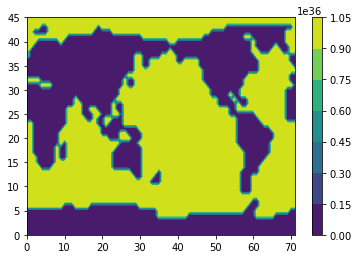

In [3]:
f_lf = nc.netcdf_file("/glade/scratch/kdagon/archive/hydro_ensemble_LHC_1/lnd/hist/hydro_ensemble_LHC_1.clm2.h0.0016-01.nc",'r', mmap=False)
lf = f_lf.variables['landfrac']
landfrac = lf[:]
#landfrac.shape
plt.contourf(landfrac)
plt.colorbar();

Mask landfrac to account for netcdf FillValues (a bit hacky)

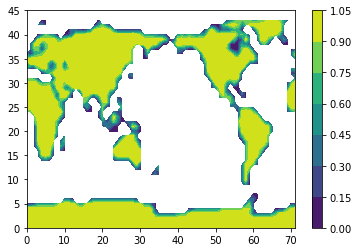

In [4]:
import numpy.ma as ma
landfrac_mask = ma.masked_where(landfrac > 1e34, landfrac) # sufficiently large to mask FillValues (~1e36)
plt.contourf(landfrac_mask)
plt.colorbar();

Read in outputdata including obs mask

In [5]:
f = nc.netcdf_file("outputdata/outputdata_"+var[0]+"_forSVD_100.nc",'r',mmap=False)
X = f.variables[var[0]]
mask = f.variables['datamask'] # key assumption is that datamask doesn't vary with time (appears that is DOES slightly in FLUXNET, something to check)
d = X[:]
m = mask[:]
#print(m.shape)
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]

Mask landfrac (again!) to match obs mask

(46, 72)


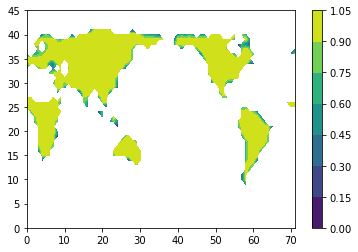

In [6]:
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)
print(landfrac_mask_obs.shape)
plt.contourf(landfrac_mask_obs)
plt.colorbar();

Perform SVD (see also SVD.py)

In [7]:
#i,j = np.nonzero(m) # or do this with landfrac (non binary mask)
i,j = np.nonzero(landfrac_mask_obs)
dr = d[:,i,j]
#dr = np.reshape(d,(nens,nlat*nlon))
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 721)
(100, 100) (100,) (100, 721)


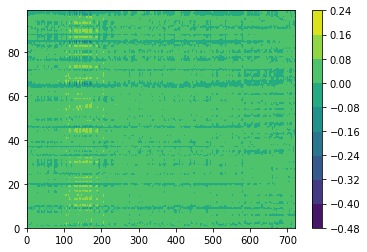

In [8]:
# Sanity check input to SVD (no FillValues!)
plt.contourf(dr)
plt.colorbar();

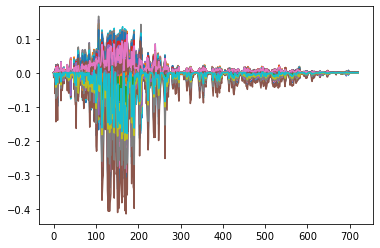

In [9]:
# each line is an ensemble member
plt.plot(np.transpose(dr));

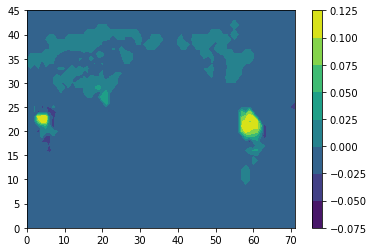

In [10]:
# plot a given ensemble member map
plt.contourf(np.where(landfrac_mask_obs==1,d[90],False))
plt.colorbar();

Calculate % variance explained

In [11]:
prop_var = s**2/np.sum(s**2)
print(100*np.sum(prop_var)) # should be ~100%
print(100*np.sum(prop_var[0:3])) # first 3 modes, total variance
print(prop_var[0:3]) # first 3 modes, individual variance

99.99999403953552
98.0880081653595
[0.83406484 0.1348919  0.01192334]


In [ ]:
# Alternate way which replaces FillValue (missing data) with 0 (doesn't change SVD result):
#dr1 = dr
#dr1[dr1==1.e+36] = 0
#U1,s1,Vh1 = np.linalg.svd(dr1, full_matrices=False)
#print(U1.shape, s1.shape, Vh1.shape)

In [ ]:
# Alternate way which removes non-land points, but with no way to reconstruct spatial maps:
#mr = np.reshape(m,nlat*nlon)
#drm = dr[:,mr==1]
#drm[drm==1.e+36] = 0
#print(drm.shape)
#U2,s2,Vh2 = np.linalg.svd(drm, full_matrices=False)
#print(U2.shape, s2.shape, Vh2.shape)

Reconstruct spatial maps

In [12]:
Vhmap = np.full((nens,nlat,nlon),np.nan)
Vhmap[:,i,j] = Vh
Vhmap.shape

(100, 46, 72)

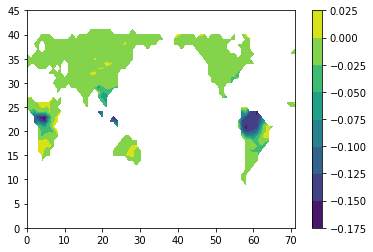

In [136]:
plt.contourf(Vhmap[0])
plt.colorbar();

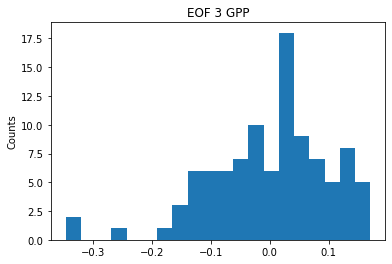

In [22]:
plt.hist(U[:,2], bins=20)
plt.ylabel("Counts")
plt.title("EOF 3 GPP");
#plt.savefig("dist_outputdata_GPP_SVD_mode3.pdf")

In [13]:
nmodes = 3

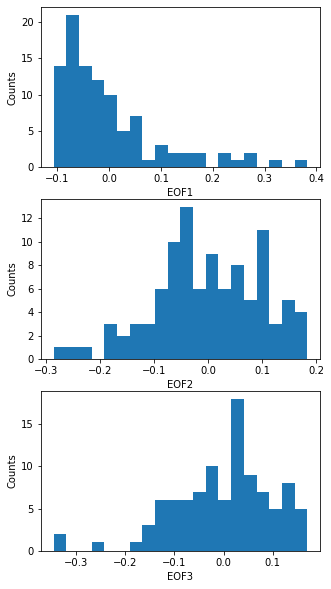

In [16]:
fig, axs = plt.subplots(nmodes, 1, figsize=(5,10))
axs = axs.ravel()
for j in range(nmodes):
    axs[j].hist(U[:,j], bins=20)
    axs[j].set_xlabel("EOF"+str(j+1))
    axs[j].set_ylabel("Counts");

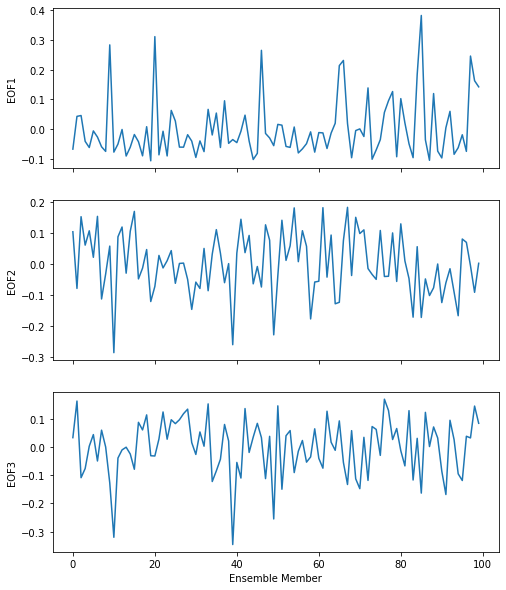

In [141]:
fig, axs = plt.subplots(nmodes, 1, figsize=(8,10), sharex=True)
axs = axs.ravel()
for j in range(nmodes):
    axs[j].plot(U[:,j])
    axs[j].set_ylabel("EOF"+str(j+1))
    if j == nmodes-1:
            axs[j].set_xlabel("Ensemble Member");
#plt.savefig("PPE_EOFseries_GPP_3modes.pdf")    

In [9]:
#from mpl_toolkits.basemap import Basemap # doesn't work in ML environment

Try with xarray for easier plotting gridding output

In [64]:
import xarray as xr

In [65]:
PPE_GPP_forSVD = xr.open_dataset("outputdata/outputdata_GPP_forSVD_100.nc")

In [66]:
PPE_GPP_forSVD_da = PPE_GPP_forSVD.GPP
PPE_GPP_forSVD_da.coords

Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0

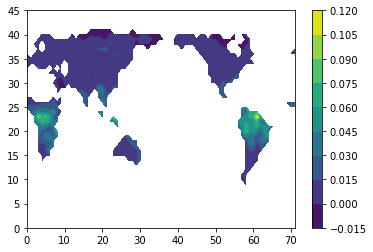

In [69]:
plt.contourf(PPE_GPP_forSVD_da[0])
plt.colorbar();

In [15]:
# Attempts to do SVD with data read in as xarray data array:
#PPE_GPP_forSVD_reshape = PPE_GPP_forSVD.GPP.stack(ngrid = ('lat','lon'))
#PPE_GPP_forSVD_reshape
#inds = np.isnan(PPE_GPP_forSVD_reshape) # this function can somehow be applied to reshape without nans
#inds
#Y = PPE_GPP_forSVD_reshape.sel(inds=True, drop=True)
#Y = PPE_GPP_forSVD_reshape.sel(np.isnan(PPE_GPP_forSVD_reshape), drop=True)
#Y = PPE_GPP_forSVD_reshape.dropna(dim='ngrid') # this works but changes the spatial dim
#PPE_GPP_forSVD_reshape[np.isnan(PPE_GPP_forSVD_reshape)] = 0
#U3,s3,Vh3 = np.linalg.svd(Y, full_matrices=False)

Convert Vhmaps to data array using xarray

In [70]:
Vhmap_xr = xr.DataArray(Vhmap, coords = PPE_GPP_forSVD_da.coords, dims=PPE_GPP_forSVD_da.dims)

In [ ]:
Vhmap_xr

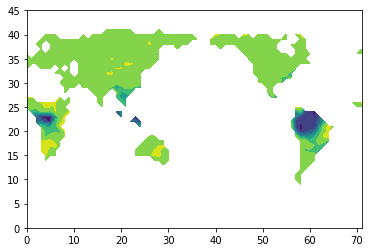

In [73]:
plt.contourf(Vhmap_xr[0]);

Need cartopy for mapping (can also integrate with xarray, see http://xarray.pydata.org/en/stable/plotting.html#maps)

In [74]:
import cartopy.crs as ccrs
import cartopy

In [77]:
# Doesn't like this, doesn't recognize lat/lon
#fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
#ax.coastlines()
#ax.contourf(Vhmap[0])

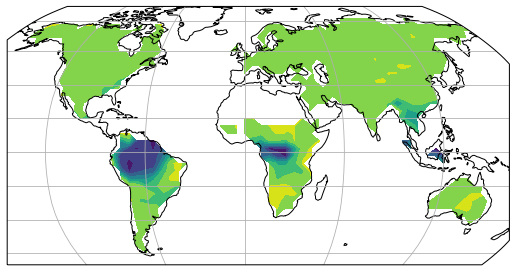

In [80]:
# This works but need to add cyclic point for continuous longitudes:
#Vhmap_mode1 = Vhmap_xr.sel(ens='2000-01-01', method='nearest')
Vhmap_mode1 = Vhmap_xr[0]
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
#Vhmap_mode1.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})
# Also need to specify lon/lat for contourf, and it cuts off global:
ax.contourf(Vhmap_mode1.lon, Vhmap_mode1.lat, Vhmap_mode1, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})

In [83]:
from cartopy.util import add_cyclic_point
field, lon = add_cyclic_point(Vhmap_mode1, coord=Vhmap_mode1.lon)
lat = Vhmap_mode1.lat

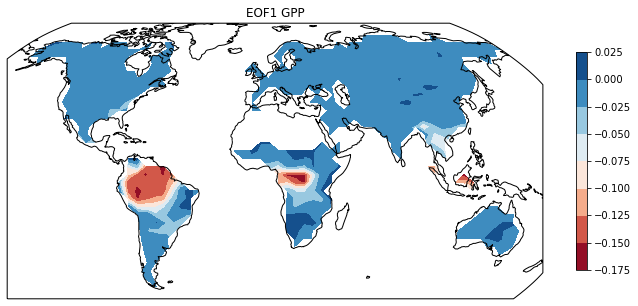

In [84]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# filled contours
cf = ax.contourf(lon, lat, field, cmap='RdBu',
                 transform=ccrs.PlateCarree());

# contour lines
#cs = ax.contour(lon, lat, field, colors='k', levels=levels, linewidths=0.5,
#                transform=ccrs.PlateCarree())

# add contour labels
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');

# land
ax.coastlines()

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
#cb.ax.set_title('mmol m$^{-3}$')
ax.set_title('EOF1 GPP');
## Why is the projection cut off (compared to the non-masked version)?
## Because contourf is subsetting only the non-missing lat/lon

In [85]:
#field, lon = add_cyclic_point(Vhmap_mode1, coord=Vhmap_mode1.lon)
#field, lon = add_cyclic_point(Vhmap_mode1.where(PPE_GPP_forSVD.datamask==1, drop=False), coord=Vhmap_mode1.lon) # or grab landfrac > 0
field, lon = add_cyclic_point(Vhmap_mode1, coord=Vhmap_mode1.lon)
lat = Vhmap_mode1.lat

In [86]:
field.shape

(46, 73)

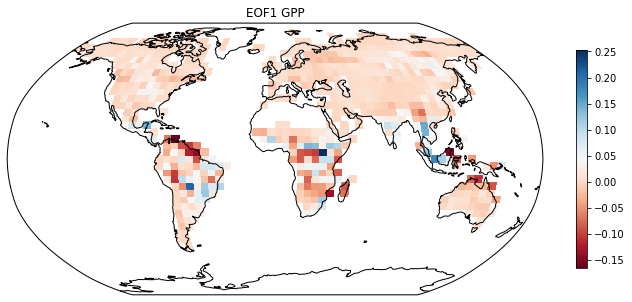

In [92]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
#ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

# filled contours
#cf = ax.contourf(lon, lat, field, cmap='RdBu',
#                 transform=ccrs.PlateCarree());

# Color mesh may be a better way to plot
# Though behavior at coastlines is not ideal
cf = ax.pcolormesh(lon, lat, field, cmap='RdBu',
                  transform=ccrs.PlateCarree());

# contour lines
#cs = ax.contour(lon, lat, field, colors='k', levels=levels, linewidths=0.5,
#                transform=ccrs.PlateCarree())

# add contour labels
#lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');

# land
ax.coastlines()

# force global map
ax.set_global()

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
#cb.ax.set_title('mmol m$^{-3}$')
ax.set_title('EOF1 GPP');

In [103]:
import matplotlib as mpl

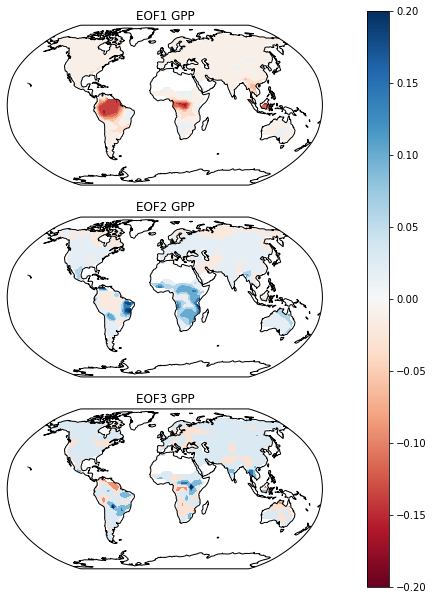

In [114]:
#fig = plt.figure(figsize=(15,10))
fig, axs = plt.subplots(nmodes, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()
for j in range(nmodes):
    Vhmap_mode = Vhmap_xr[j]
    field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
    lat = Vhmap_mode.lat
    #ax = fig.add_subplot(1,j+1,j+1, projection = ccrs.Robinson())
    cf = axs[j].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #cf = axs[j].pcolormesh(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #print(cf.get_clim())
    axs[j].coastlines()
    axs[j].set_global()
    #cb = plt.colorbar(cf)
    #cb = plt.colorbar(cf, shrink=0.5)
    #cb = fig.colorbar(cf, ax=axs[j])
    axs[j].set_title('EOF'+str(j+1)+' GPP')

cb_ax = fig.add_axes([0.7, 0.1, 0.02, 0.8])
#cbar = fig.colorbar(cf, cax=cb_ax)
#cbar = fig.colorbar(cf, axs.tolist(), shrink=0.95)

# more colorbar options (e.g., set bounds)
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm)

#plt.savefig("PPE_EOFmaps_GPP_3modes.pdf")

## How do I ensure that the panels all use the same color scale?
## Sanity check "print(cf.get_clim)"

### Now for LHF

In [14]:
f = nc.netcdf_file("outputdata/outputdata_"+var[1]+"_forSVD_100.nc",'r',mmap=False)
X = f.variables[var[1]]
mask = f.variables['datamask'] # key assumption is that datamask doesn't vary with time (appears that is DOES slightly in FLUXNET, something to check)
d = X[:]
m = mask[:]
#print(m.shape)
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)
i_ind,j_ind = np.nonzero(landfrac_mask_obs)
dr = d[:,i_ind,j_ind]
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 722)
(100, 100) (100,) (100, 722)


Calculate % variance explained

In [15]:
prop_var = s**2/np.sum(s**2)
print(100*np.sum(prop_var)) # should be ~100%
print(100*np.sum(prop_var[0:3])) # first 3 modes, total variance
print(prop_var[0:3]) # first 3 modes, individual variance

100.0
95.57834267616272
[0.7701996  0.12915632 0.05642754]


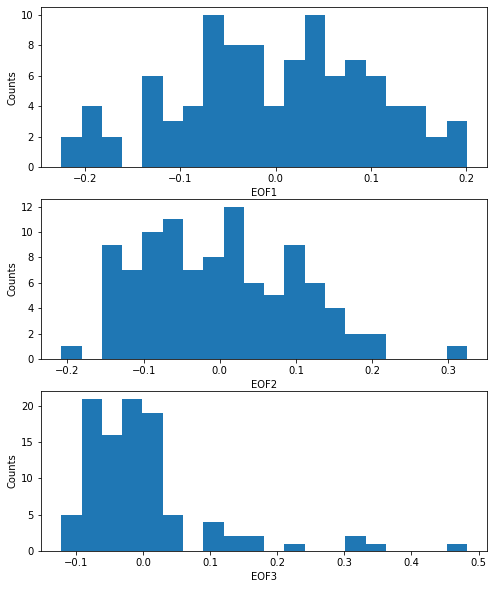

In [164]:
fig, axs = plt.subplots(nmodes, 1, figsize=(8,10))
axs = axs.ravel()
for j in range(nmodes):
    axs[j].hist(U[:,j], bins=20)
    axs[j].set_xlabel("EOF"+str(j+1))
    axs[j].set_ylabel("Counts");

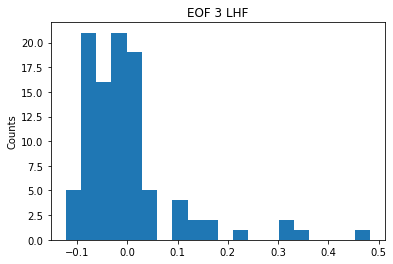

In [28]:
plt.hist(U[:,2], bins=20)
plt.ylabel("Counts")
plt.title("EOF 3 LHF");
#plt.savefig("dist_outputdata_LHF_SVD_mode3.pdf")

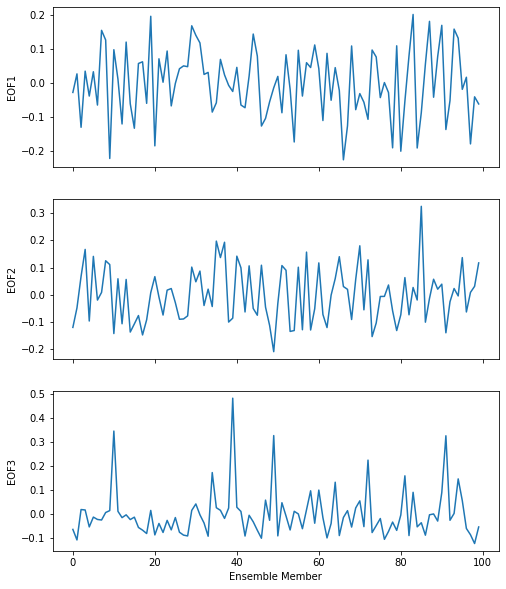

In [24]:
fig, axs = plt.subplots(nmodes, 1, figsize=(8,10), sharex=True)
axs = axs.ravel()
for j in range(nmodes):
    axs[j].plot(U[:,j])
    axs[j].set_ylabel("EOF"+str(j+1))
    if j == nmodes-1:
            axs[j].set_xlabel("Ensemble Member");
#plt.savefig("PPE_EOFseries_LHF_3modes.pdf")    

Reconstruct spatial maps

In [166]:
Vhmap = np.full((nens,nlat,nlon),np.nan)
Vhmap[:,i_ind,j_ind] = Vh
Vhmap.shape

(100, 46, 72)

In [167]:
PPE_LHF_forSVD = xr.open_dataset("outputdata/outputdata_LHF_forSVD_100.nc")

In [168]:
PPE_LHF_forSVD_da = PPE_LHF_forSVD.LHF
PPE_LHF_forSVD_da.coords

Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0

In [169]:
Vhmap_xr = xr.DataArray(Vhmap, coords = PPE_LHF_forSVD_da.coords, dims=PPE_LHF_forSVD_da.dims)

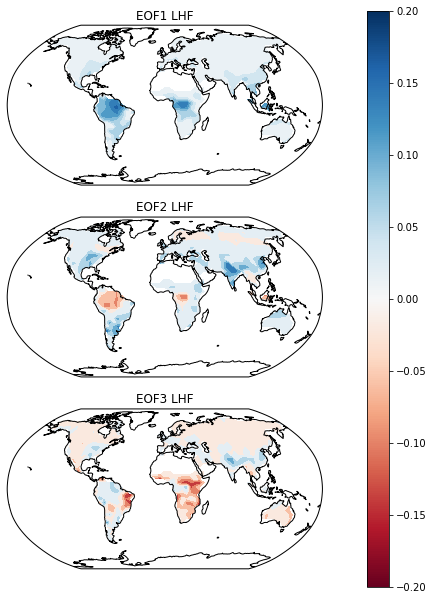

In [176]:
fig, axs = plt.subplots(nmodes, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()
for j in range(nmodes):
    Vhmap_mode = Vhmap_xr[j]
    field, lon = add_cyclic_point(Vhmap_mode, coord=Vhmap_mode.lon)
    lat = Vhmap_mode.lat
    #ax = fig.add_subplot(1,j+1,j+1, projection = ccrs.Robinson())
    cf = axs[j].contourf(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #cf = axs[j].pcolormesh(lon, lat, field, cmap='RdBu',transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2);
    #print(cf.get_clim())
    axs[j].coastlines()
    axs[j].set_global()
    axs[j].set_title('EOF'+str(j+1)+' LHF')

cb_ax = fig.add_axes([0.7, 0.1, 0.02, 0.8])

cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm)

#plt.savefig("PPE_EOFmaps_LHF_3modes.pdf")